# Imports

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from scipy.special import sph_harm
import pyvista as pv
from tqdm import tqdm

from atomview.utils import complex_to_rgba

# Generic

In [2]:
def sph_harm_real(l, m, theta, phi):
    ylm = sph_harm(np.abs(m), l, phi, theta)
    if m > 0:
        ylm = np.sqrt(2) * (-1)**m * np.real(ylm)
    elif m < 0:
        ylm = np.sqrt(2) * (-1)**m * np.imag(ylm)
    return ylm

In [3]:
fig_dir = Path(Path.cwd(), 'figures', 'sph_harm_figs')
fig_dir.mkdir(exist_ok=True, parents=True)

# 2D Plots

In [4]:
def plot_sph_harm_color_map(l, m, real=False, ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))

    theta_1d = np.linspace(0, np.pi, 100)
    phi_1d = np.linspace(0, 2 * np.pi, 100)
    
    theta, phi = np.meshgrid(theta_1d, phi_1d, indexing='ij')


    if real:
        ylm = sph_harm_real(l, m, theta, phi)
    else:
        ylm = sph_harm(m, l, phi, theta)
            
    color_map = complex_to_rgba(ylm, mag_maps_to='s')
    
    ax.imshow(color_map, extent=[0, 2, 1, 0], aspect=2)
    ax.grid(False)
    ax.set_xlabel('$\\phi$')
    ax.set_ylabel('$\\theta$')
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(labels=['0', '$\\pi$', '$2\\pi$'])
    ax.set_yticks([0, 0.5, 1])
    ax.set_yticklabels(labels=['0', '$\\pi/2$', '$\\pi$'])
    

def plot_sph_harm_table(max_l, real=False, save_path=None):
    num_rows = max_l + 1
    num_cols = 2 * max_l + 1
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*3, num_rows*3))

    for row in range(num_rows):
        for col in range(num_cols):
            ax = axes[row, col]
            ax.axis('off')
    
    for l in range(max_l + 1):
        for m in range(-l, l+1):
            ax = axes[l, max_l + m]
            ax.axis('on')
            if m == 0:
                ax.set_title(f'$(\ell, m) = ({l}, {m})$')
            else:
                ax.set_title(f'$(\ell, m) = ({l}, {m:+})$')
            plot_sph_harm_color_map(l, m, real=real, ax=ax)

    fig.set_tight_layout(True)
    if save_path is not None:
        fig.savefig(save_path, facecolor='white')
    
    plt.show()

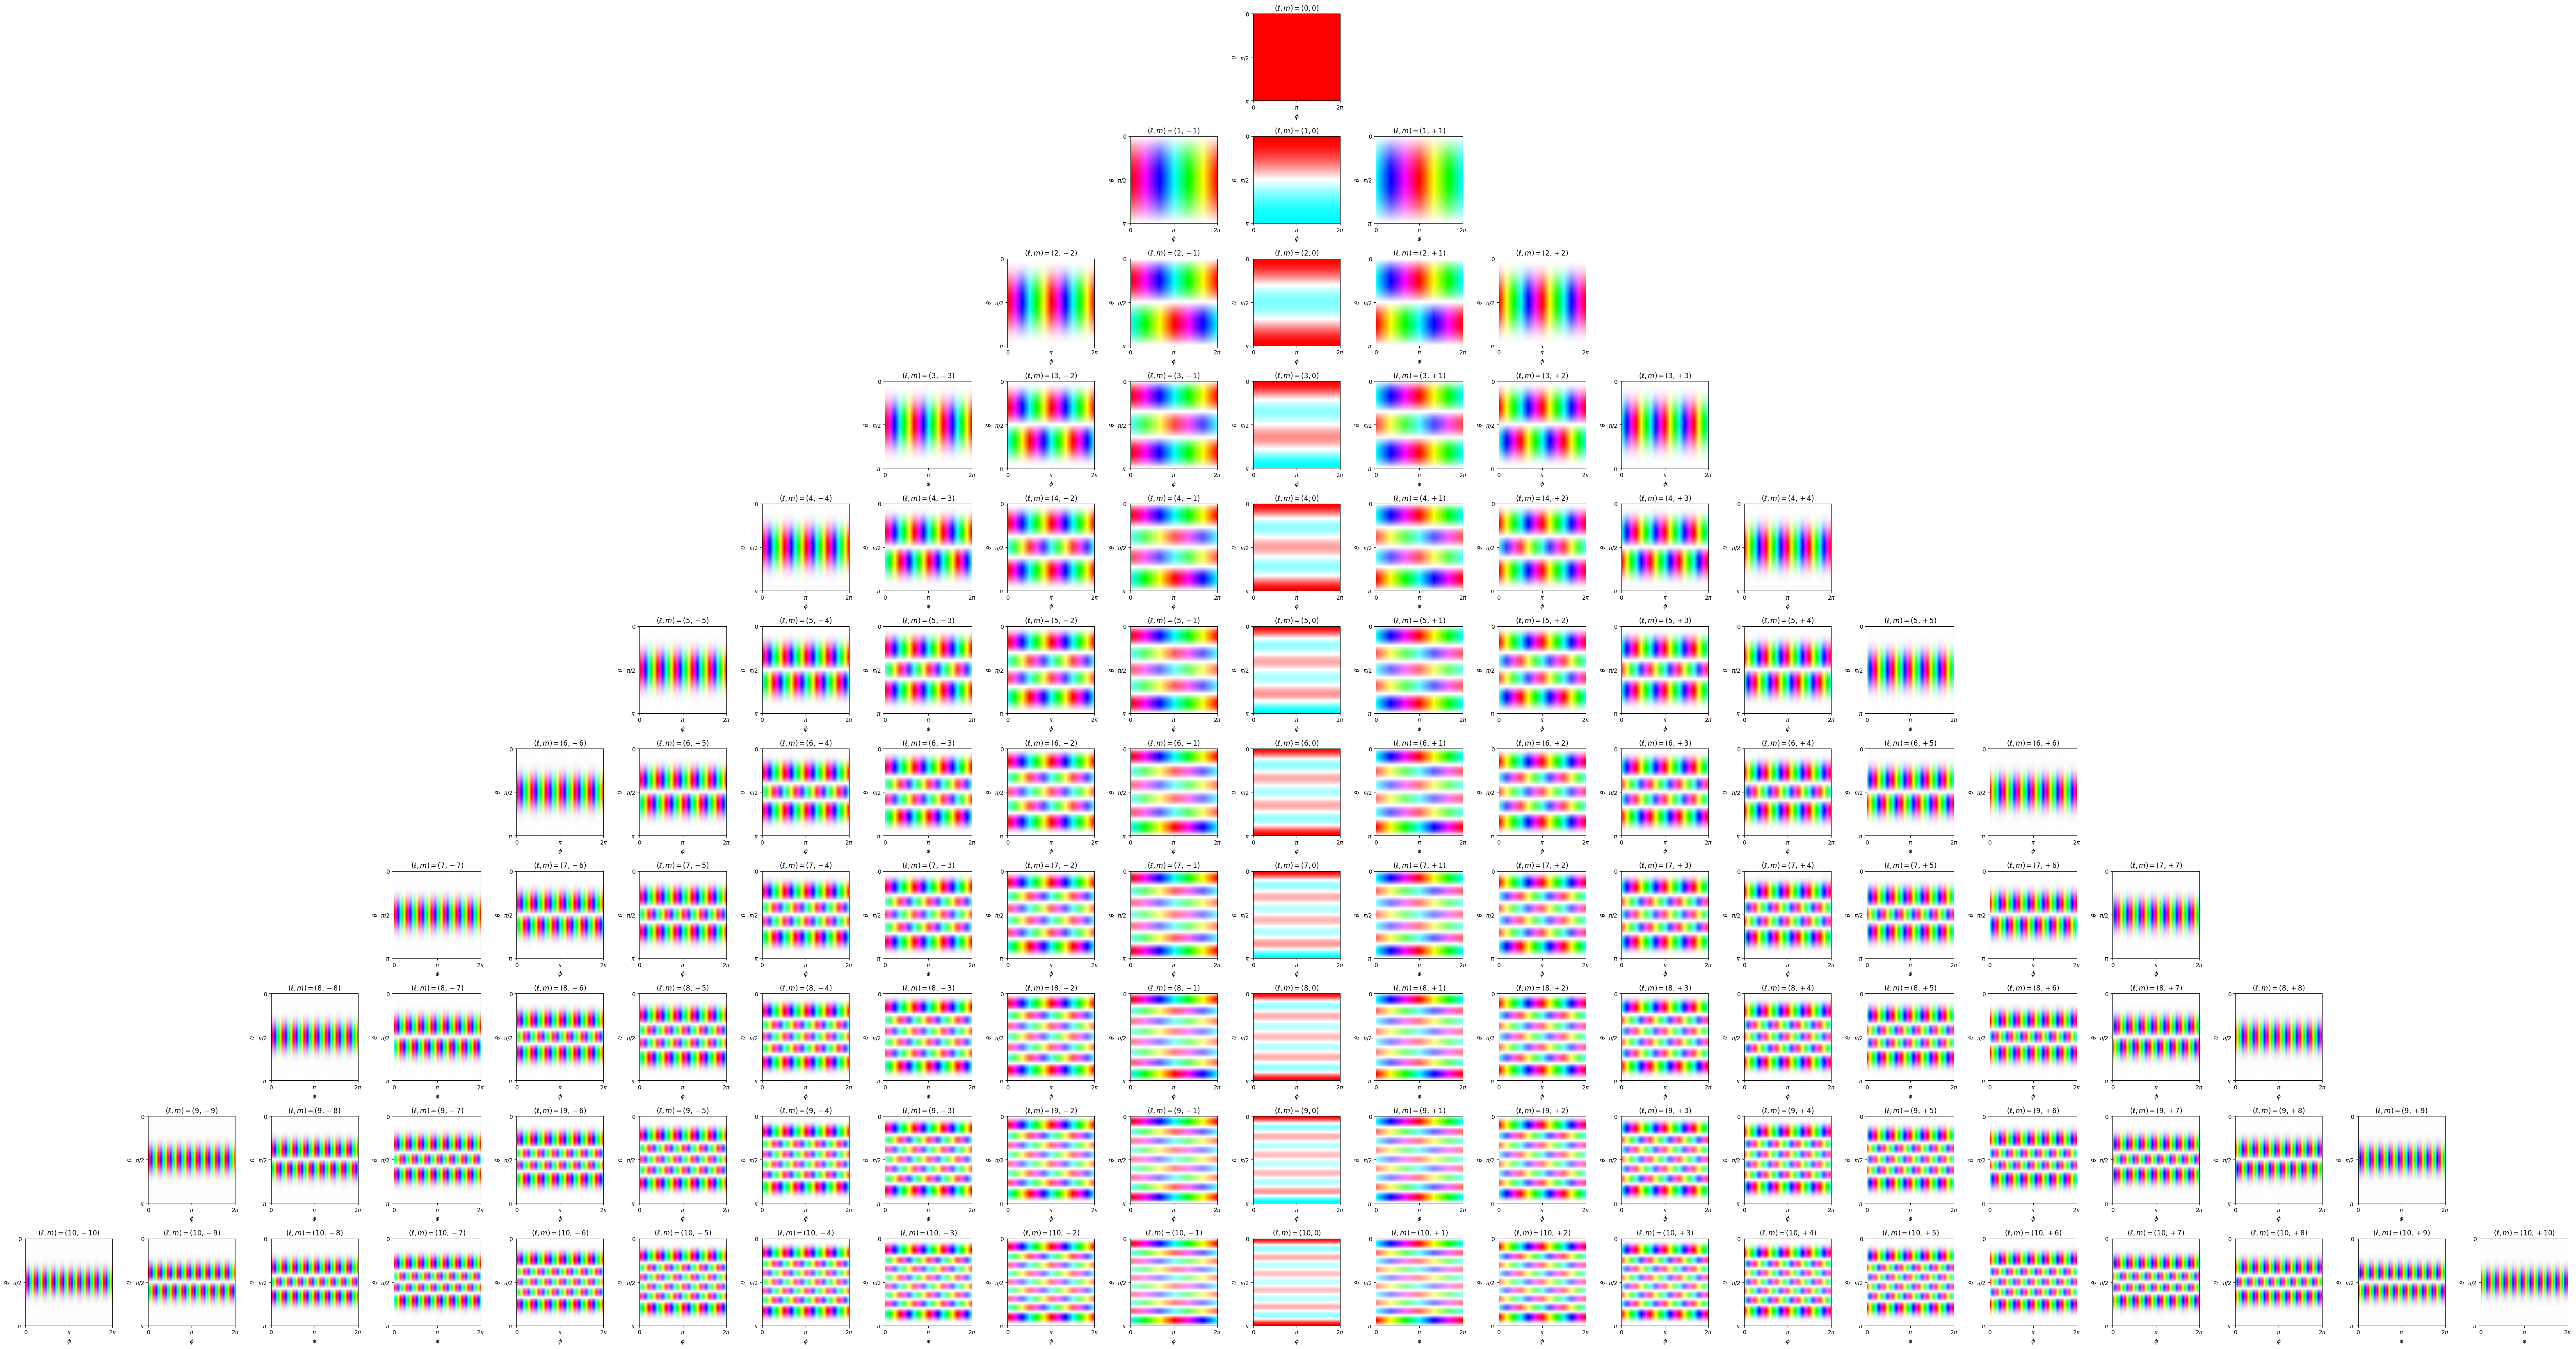

In [5]:
fig_path = Path(fig_dir, 'complex_2d.png')
plot_sph_harm_table(10, real=False, save_path=fig_path)

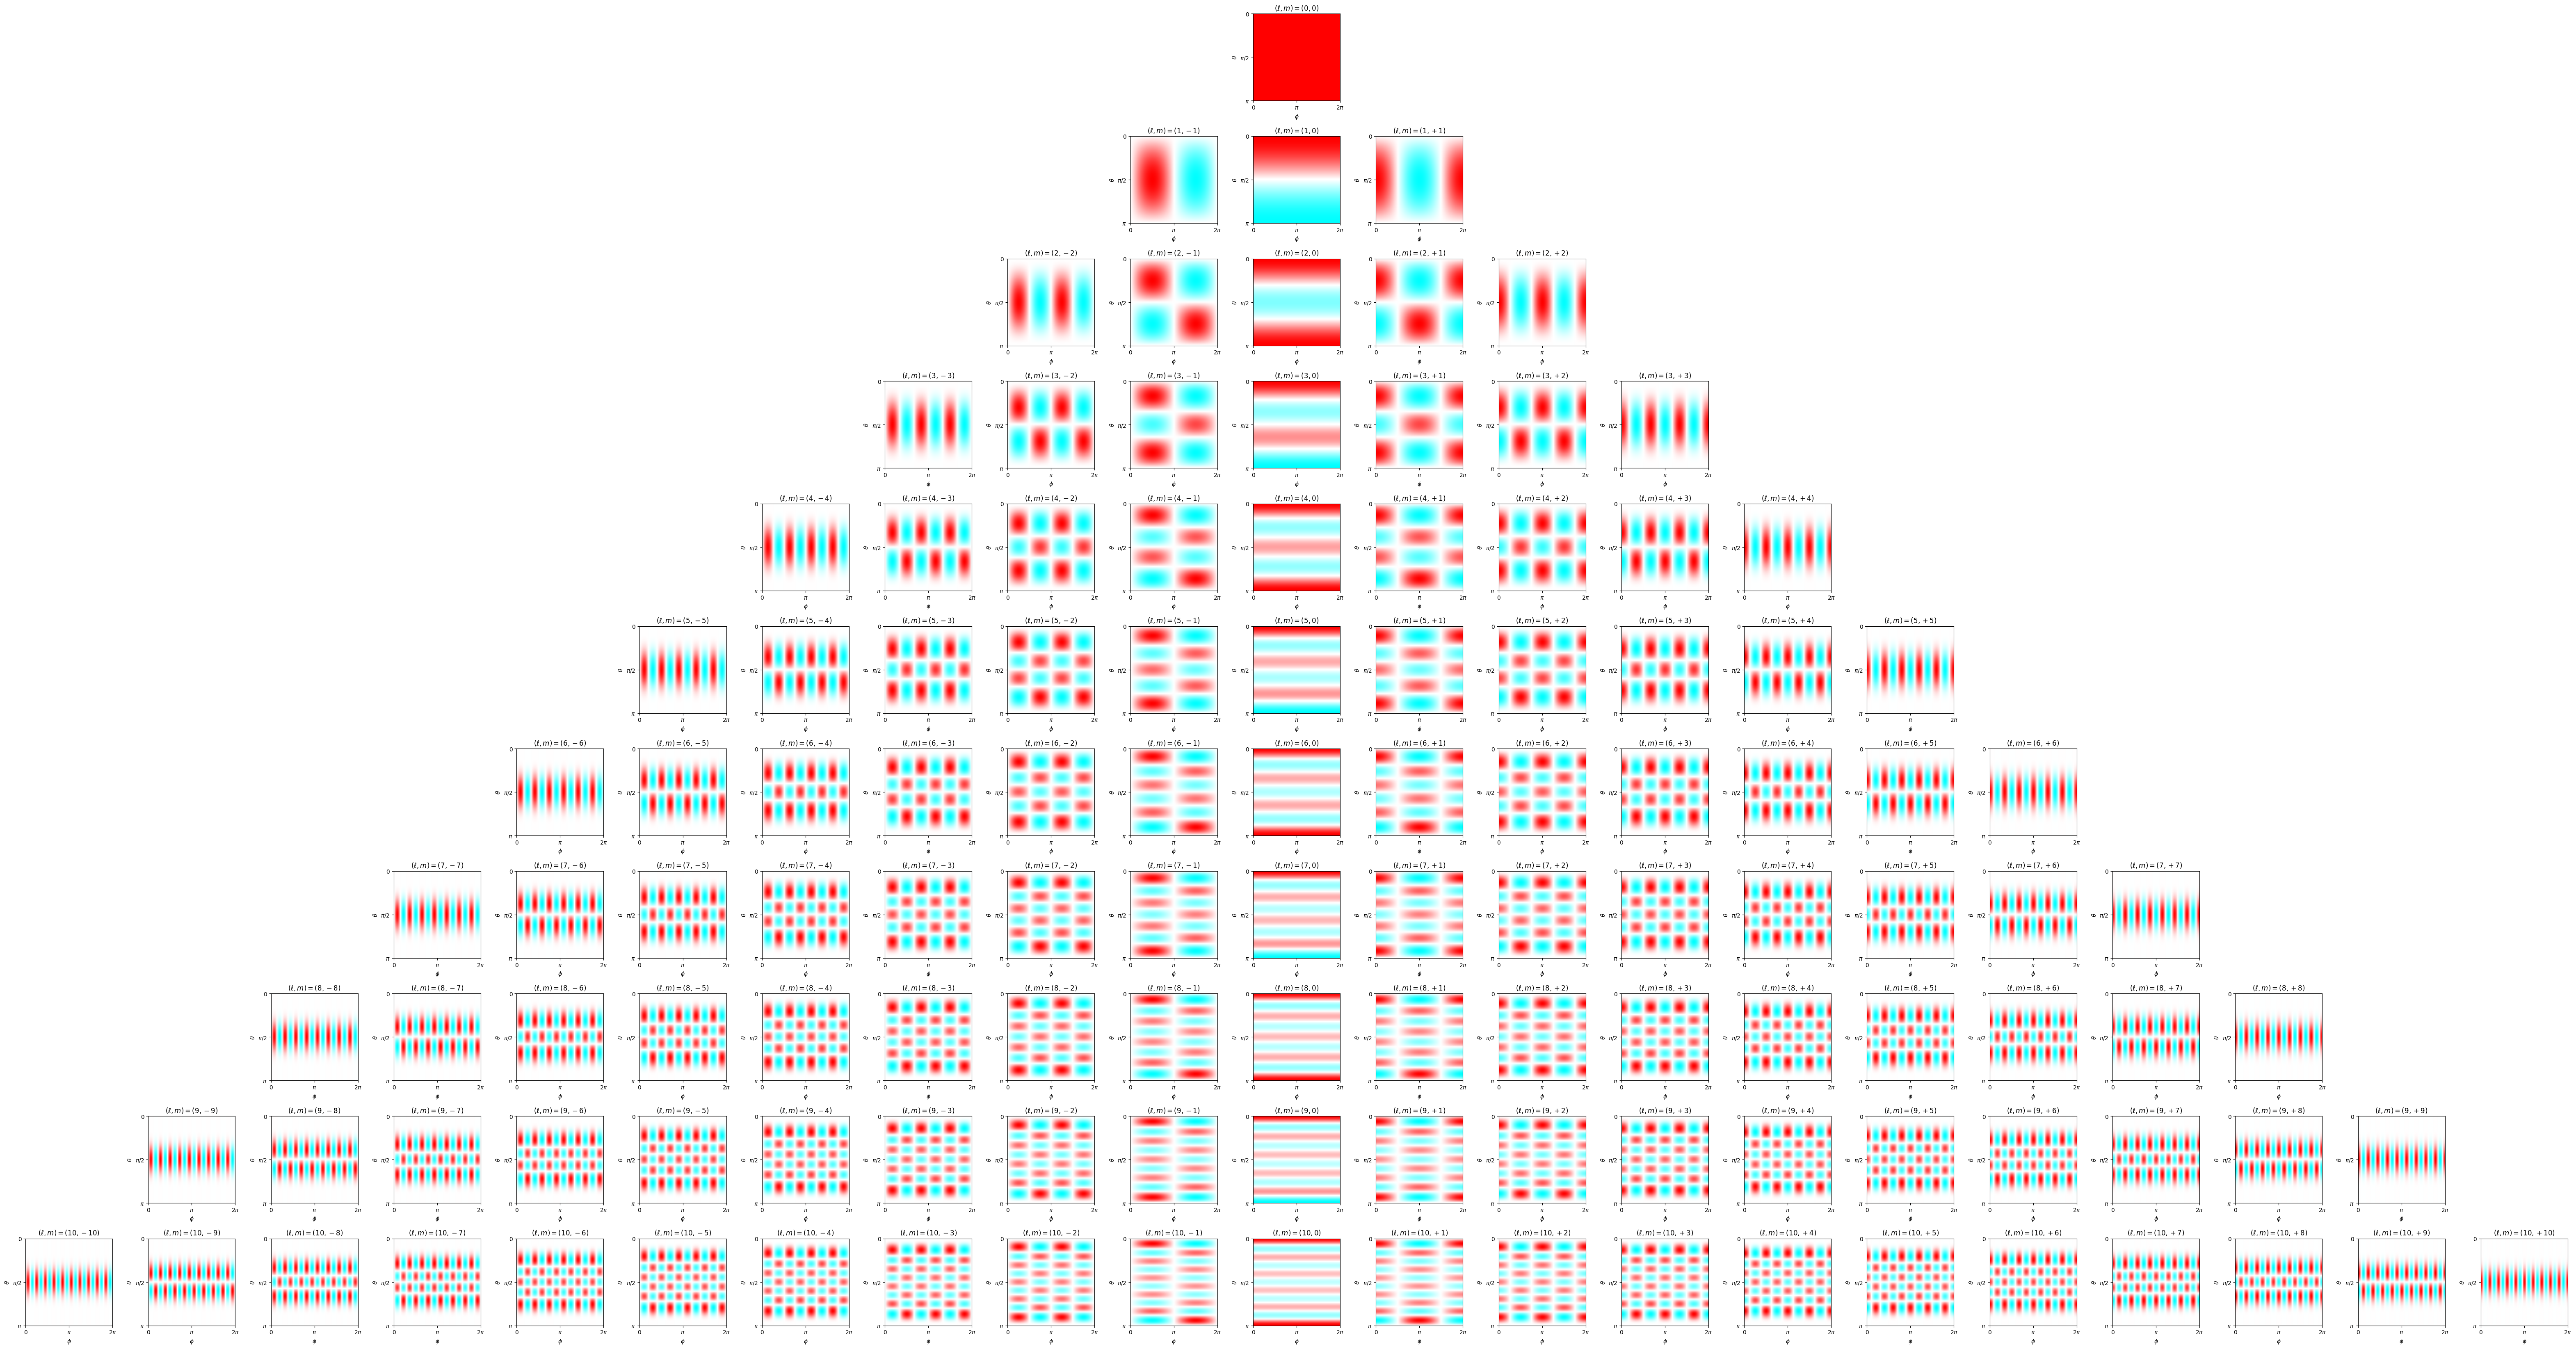

In [6]:
fig_path = Path(fig_dir, 'real_2d.png')
plot_sph_harm_table(10, real=True, save_path=fig_path)

# 3D Plots

In [4]:
def get_sph_harm_3d_mesh(l, m, real=False, radius_from_mag=True, mag_maps_to=''):
    theta_1d = np.linspace(0, np.pi, 100)
    phi_1d = np.linspace(0, 2 * np.pi, 100)
    
    theta, phi = np.meshgrid(theta_1d, phi_1d, indexing='ij')

    if real:
        ylm = sph_harm_real(l, m, theta, phi)
    else:
        ylm = sph_harm(m, l, phi, theta)
            
    if radius_from_mag:
        r = np.abs(ylm)
        r /= np.max(r)
    else:
        r = np.ones_like(ylm, dtype=float)

    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)

    rgba = complex_to_rgba(ylm.ravel(order='F'), mag_maps_to=mag_maps_to)
    
    mesh = pv.StructuredGrid(x, y, z)
    mesh['rgba'] = rgba

    return mesh

In [9]:
def plot_3d_sph_harm_table(lmax, gif_path, real=False, radius_from_mag=True, mag_maps_to='',
                           gif_duration_ms=2000, fps=10):
    plotter = pv.Plotter(shape=(lmax + 1, 2 * lmax + 1), 
                         border=False, notebook=False,
                         window_size=[2048, 1536],
                         off_screen=True)
    
    for l in tqdm(range(0, lmax + 1), desc='generating meshes'):
        for m in range(-l, l+1):
            plotter.subplot(l, m + lmax)        
            mesh = get_sph_harm_3d_mesh(
                       l, m, real=real,
                       radius_from_mag=radius_from_mag,
                       mag_maps_to=mag_maps_to
            )
            plotter.add_mesh(
                mesh, 
                scalars='rgba', 
                rgb=True,   
                smooth_shading=True,        
                specular=0,
                diffuse=1,
                ambient=0.3
            )
            plotter.add_text(f'(l, m) = ({l}, {m})', font_size=10)

    plotter.open_movie(str(Path(gif_path).with_suffix('.mp4')), framerate=fps, quality=10)
    # plotter.open_gif(str(Path(gif_path).with_suffix('.gif')), fps=fps, subrectangles=True)

    cam_r = 6
    cam_theta = np.pi / 3

    num_frames = int(gif_duration_ms * 1e-3 * fps)
    cam_phi_list = np.linspace(0, 2 * np.pi, num_frames, endpoint=False)    
    
    for cam_phi in tqdm(cam_phi_list, desc='Making Phi Frames'):
        cam_x = cam_r * np.sin(cam_theta) * np.cos(cam_phi)
        cam_y = cam_r * np.sin(cam_theta) * np.sin(cam_phi)
        cam_z = cam_r * np.cos(cam_theta)
        new_cam_position = (cam_x, cam_y, cam_z)
        for l in range(0, lmax + 1):
            for m in range(-lmax, lmax+1):
                plotter.subplot(l, m + lmax)        
                plotter.camera.position = new_cam_position
        plotter.write_frame()

    plotter.close()


In [10]:
lmax = 10

fig_path = Path(fig_dir, 'complex_3d_radius.mp4')
plot_3d_sph_harm_table(lmax, fig_path, real=False,
                       radius_from_mag=True, mag_maps_to='',
                       gif_duration_ms=3000, fps=10)

fig_path = Path(fig_dir, 'complex_3d_sphere.mp4')
plot_3d_sph_harm_table(lmax, fig_path, real=False,
                       radius_from_mag=False, mag_maps_to='s',
                       gif_duration_ms=3000, fps=10)

fig_path = Path(fig_dir, 'real_3d_radius.mp4')
plot_3d_sph_harm_table(lmax, fig_path, real=True,
                       radius_from_mag=True, mag_maps_to='',
                       gif_duration_ms=3000, fps=10)

fig_path = Path(fig_dir, 'real_3d_sphere.mp4')
plot_3d_sph_harm_table(lmax, fig_path, real=True,
                       radius_from_mag=False, mag_maps_to='s',
                       gif_duration_ms=3000, fps=10)

Making Phi Frames: 100%|███████████████████████████████████████████████████████████████| 30/30 [00:08<00:00,  3.50it/s]


In [ ]:
fig_path